# PCA原理
数据矩阵的秩K-近似逼近


# PCA 进行数据降维并应用于 MNIST 数据集

本 notebook 演示了如何使用 PCA（主成分分析）对数据进行降维，并将其应用于 MNIST 数据集。然后我们将使用降维后的数据训练一个简单的多层感知机（MLP）模型。

## 导入必要的库


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from scipy.io import loadmat
from numpy.linalg import svd

## 定义数据转换

我们将使用 `ToTensor` 将图像数据转换为张量，并使用 `Normalize` 进行标准化。


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## 定义 PCA 相关函数

以下函数将用于进行 PCA 降维。

In [4]:
def pca(X):
    # normalize the features
    X = (X - X.mean()) / X.std()
    
    # compute the covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    
    # perform SVD
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

def project_data(X, U, k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

def recover_data(Z, U, k):
    U_reduced = U[:,:k]
    return np.dot(Z, U_reduced.T)

## 加载和处理数据

我们将下载和加载 MNIST 数据集，然后对数据进行降维处理。

In [52]:
#定义一个全局变量让下面的代码更好看
global_k=0
U=None
V=None
S=None

In [54]:
def find_k(S, rate):
    global global_k
    if(global_k!=0):
        return global_k
    level = np.square(S).sum() * rate
    cumulative_sum = np.cumsum(np.square(S))
    k = np.searchsorted(cumulative_sum, level) + 1
    global_k=k
    return k

def trans(trainset, rate=0.90):
    global U,V,S
    # 获取所有的训练数据
    train_data = trainset.data.numpy()
    num_samples, height, width = train_data.shape

    # 将二维图像数据转换为一维向量
    train_data_flat = train_data.reshape(num_samples, -1)

    # 计算SVD
    if(V is None):
        U, S, V = np.linalg.svd(train_data_flat, full_matrices=False)
    k = find_k(S, rate)
    print("k_value: ",k,"\nnum_samples: ",num_samples)
    
    # 降维处理
    train_data_reduced = np.dot(train_data_flat, V[:k].T)

    # 创建新的数据集，并替换原始数据集的训练部分
    trainset_reduced = TensorDataset(torch.tensor(train_data_reduced).float(), trainset.targets)
    return trainset_reduced

# 下载和加载训练集
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainset_reduced = trans(trainset)

trainloader = torch.utils.data.DataLoader(trainset_reduced, batch_size=64, shuffle=True,drop_last=True)

# 下载和加载测试集
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testset_reduced = trans(testset)
testloader = torch.utils.data.DataLoader(testset_reduced, batch_size=64, shuffle=False)


k_value:  53 
num_samples:  60000
k_value:  53 
num_samples:  10000


## 定义 MLP 模型

我们将定义一个简单的多层感知机（MLP）模型。

In [61]:
import math
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # 初始化参数
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)
    
    def _initialize_weights(self):
    # 使用何凯明方法初始化模型参数
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(layer.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(layer.bias, -bound, bound)


## 训练和评估模型

我们将定义训练和评估模型的函数。


In [59]:
def train(model, train_loader, optimizer, criterion, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        train_losses.append(running_loss)
        test_loss, test_accuracy = test(model, testloader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    plot_results(train_losses, test_losses, test_accuracies)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

def plot_results(train_losses, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # 绘制训练和测试损失
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # 绘制测试准确率
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



## 初始化和训练模型


[1,   100] loss: 37.196
[1,   200] loss: 2.693
[1,   300] loss: 2.183
[1,   400] loss: 2.055
[1,   500] loss: 1.930
[1,   600] loss: 1.867
[1,   700] loss: 1.771
[1,   800] loss: 1.690
[1,   900] loss: 1.709
Epoch 1/25, Test Loss: 0.0267, Test Accuracy: 0.4128
[2,   100] loss: 1.659
[2,   200] loss: 1.629
[2,   300] loss: 1.571
[2,   400] loss: 1.531
[2,   500] loss: 1.565
[2,   600] loss: 1.556
[2,   700] loss: 1.522
[2,   800] loss: 1.532
[2,   900] loss: 1.537
Epoch 2/25, Test Loss: 0.0236, Test Accuracy: 0.4912
[3,   100] loss: 1.416
[3,   200] loss: 1.441
[3,   300] loss: 1.400
[3,   400] loss: 1.417
[3,   500] loss: 1.322
[3,   600] loss: 1.380
[3,   700] loss: 1.326
[3,   800] loss: 1.350
[3,   900] loss: 1.321
Epoch 3/25, Test Loss: 0.0204, Test Accuracy: 0.5626
[4,   100] loss: 1.269
[4,   200] loss: 1.211
[4,   300] loss: 1.183
[4,   400] loss: 1.234
[4,   500] loss: 1.232
[4,   600] loss: 1.186
[4,   700] loss: 1.156
[4,   800] loss: 1.153
[4,   900] loss: 1.123
Epoch 4/25, 

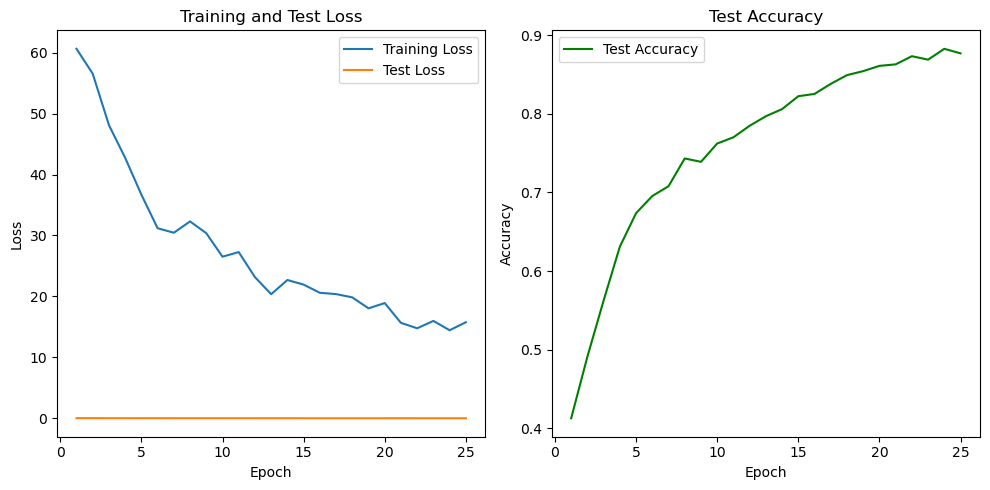

In [62]:
input_size = trainset_reduced[0][0].shape[0]
model = MLP(input_size)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)

# 训练模型
train(model, trainloader, optimizer, criterion, epochs=25)


## 可见，PCA去掉了90%的维度还能有效地保留样本之间的差异，是个绝妙的策略